# 9hour _stategy
------------
## 배경 
+ 한국 시간 기준 9시 정각에 코인 시가가 시작 된다. 특히 이 시간에는 거래량이 타 시간대에 비해 많다. 9시에 장을 보면서 찾은 규칙은 전날 급등했던 코인은 또 다시 주목을 받을 확률이 크며 큰 변동을 보인다. 횡보하는 경우도 있지만 대개 큰 폭으로 하락하거나 큰 폭으로 상승한다. 손절선을 정해주어 손실을 최소화하면서 급등을 따라간다면 분명 수익이 발생할 것으로 예상한다. 
    
## 전략 내용
+ 한국 시간 기준 9시 정각에 전일 상승률이 top 5안에 드는 코인에 균일한 비중으로 분산 투자를 진행한다.(top5안에 들었지만 상승률이 5퍼센트가 안된다면 하락장으로 판단하여 리스트에 추가하지 않는다. 이 경우에는 투자를 안할 수도 있음.) 그리고 아래와 같은 경우의 수를 고려하여 매도를 진행한다.<br><br>
    1) 손절가가 형성되면 시간에 관계없이 전량 매도 <br>
    2) 손절가가 오기 이전에 상승률이 10%일 경우 절반 익절(5% 수익) 후 다시 상승률이 50%가 넘어갈 경우 전량매도(37% 수익) <br>
    3) 손절가가 오기 이전에 상승률이 10%일 경우 절반 익절(5%) 후 0% 상승률로 떨어질 경우 익절(5% 수익) <br>
    4) 손절가에 접근하지 않았으며 상승률이 10% 미만일 경우 그날의 장마감 때 전량 매도(그날의 일일 수익률) <br>
    5) 손절가가 오기 이전에 상승률이 10%일 경우 절반 익절(5%) 후 0% 상승률로 떨어지지 않을 경우 그날의 장마감 때 전량 매도(5% + 0.55 * 종가 수익률)<br> 
  
## +a 
+ 전날 종가가 5일 이평선 위에 있을 경우에만 매수 (하락장에는 매매를 하지 않기 위함) -> 수익률 좋지 않음.
+ 전날 종가가 20일 이평선 위에 있을 경우에만 매수 (하락장에는 매매를 하지 않기 위함) -> 5일 이평보단 나음
+ 전날 코인 인덱스(전체 인덱스 or 알트 인덱스)가 +로 마감할 경우에만 매수 / 인덱스 과거 데이터를 찾기 힘드므로 비트코인 인덱스만을 사용. 
 

In [2]:
import pyupbit
import time
from datetime import datetime, timedelta
from pytz import timezone, utc
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import trange, notebook
from bs4 import BeautifulSoup

pd.options.display.max_rows = 1441

In [6]:
def get_rate(p1, p2):
    return round(((p1/p2 - 1) * 100), 2)

def date_range(start, end):
    start = datetime.strptime(start, "%Y-%m-%d")
    end = datetime.strptime(end, "%Y-%m-%d")
    dates = [(start + timedelta(days=i)).strftime("%Y-%m-%d") for i in range((end-start).days+1)]
    return dates  

def generate_pick_coins(date):
    btc_price = pyupbit.get_ohlcv(ticker="KRW-BTC", to=date, count=1)
    try:
        btc_index = get_rate(btc_price.close.values[-1], btc_price.open.values[-1])
    except Exception as e:
        print(e)
        btc_index = 0
        pass
    
    if btc_index > 0:
        coins = pyupbit.get_tickers(fiat="KRW")
        coins_rate = []
        
        for coin in coins:
            time.sleep(0.1)
            try:
                coin_price = pyupbit.get_ohlcv(ticker=coin, to=date, count=20)
                ma = coin_price["close"].mean() # count 일 동안의 이평선          
            except Exception as e:
                continue
            open_price = coin_price.open.values[-1]
            close_price = coin_price.close.values[-1]
            coin_rate = get_rate(close_price, open_price)

            if coin_rate > 5 and close_price >= ma:
                yield [date, coin, coin_rate, btc_index]

def get_pick_coins(date):
    picked_coins = sorted(generate_pick_coins(date), key = lambda x : -x[2])[0:5]
    return picked_coins

def get_missing_value_frame(df, date):
    tomorrow = get_tomorrow(date)
    df["DATE"] = pd.to_datetime(df.index)
    df = df[f'{date} 09:00:00':f'{tomorrow} 09:00:00']
    df = df.resample(rule='min').last()
    df = df.fillna(method='ffill')
    return df

def get_coin_data(coins_name):
    for date, coin in coins_name:
        coin_dict = {}
        coin_dict["name"] = coin
        coin_dict["data"] = get_missing_value_frame(pyupbit.get_ohlcv(coin, count=1441, 
                                            to=datetime.strptime(f"{date} 9:01:00", "%Y-%m-%d %H:%M:%S")
                                            + timedelta(1) ,interval="minute1"), date) 
        
        coin_dict['open'] = coin_dict["data"].iloc[0]['open']
        coin_dict['close'] = coin_dict["data"].iloc[-1]['close']
        yield coin_dict
        
def get_tomorrow(date:str) -> str:
    tomorrow = datetime.strptime(date, '%Y-%m-%d') + timedelta(1)
    return tomorrow.strftime('%Y-%m-%d')

def get_avg(result):
    mount = 0
    for rate in result:
        a = list(rate.values())
        mount += a[0][0]
    avg = mount / len(result)

    return avg

def backtest(date):
    if pick_coins := get_pick_coins(date):
        coins_name = [(coin[0], coin[1]) for coin in pick_coins]
        return_rate = []
        for price in get_coin_data(coins_name):
            coin_dict = {}
            coin_dict[price["name"]] = (0, 0)
            check = None

            for idx, p in price["data"].iterrows():

                if get_rate(p[3], price['open']) <= -3:
                    coin_dict[price["name"]] = (-3, 1) # 손절
                    return_rate.append(coin_dict)
                    print(coin_dict)
                    break

                if get_rate(p[3], price['open']) > 10:
                    check = "half" 

                if check == "half" and get_rate(p[3], price['open']) <= 0:
                    coin_dict[price["name"]] = (5, 2)  # 경우 2
                    return_rate.append(coin_dict)
                    print(coin_dict)
                    break

                if check == "half" and get_rate(p[3], price['open']) > 50:
                    coin_dict[price["name"]] = (37, 3) # 경우 1
                    return_rate.append(coin_dict)
                    print(coin_dict)
                    break


                if idx == pd.to_datetime(f"{get_tomorrow(date)} 09:00:00") and check == "half": # 경우 3
                    coin_dict[price["name"]] = (5 + 0.55 * get_rate(price['close'], price['open']), 4)
                    return_rate.append(coin_dict)
                    print(coin_dict)
                    break

                if idx == pd.to_datetime(f"{get_tomorrow(date)} 09:00:00"): # 경우 4
                    coin_dict[price["name"]] = (get_rate(price['close'], price['open']), 5)
                    return_rate.append(coin_dict)
                    print(coin_dict)
                    break

        rr = 0
        if len(return_rate):
            rr = get_avg(return_rate) * (len(return_rate) / 5)

        return rr, pick_coins[0][-1]
    
    else:
        btc_price = pyupbit.get_ohlcv(ticker="KRW-BTC", to=date, count=1)
        try:
            btc_index = get_rate(btc_price.close.values[-1], btc_price.open.values[-1])
        except Exception as e:
            print(e)
            btc_index = 0
        
        return 0, btc_index

def get_backtesting_data_frame(start, end):
    result = []
    for date in notebook.tqdm(date_range(start, end)):
        return_rate, btc_idx = backtest(date)
        result.append([date, return_rate, btc_idx])

    df = pd.DataFrame(result, columns=['Date', 'dr', 'btc_idx'])  # daily return rate
    df["crr"] = ((100 + df['dr'])/100).cumprod()
    df['mdd'] = (df['crr'].cummax() - df['crr']) / df['crr'].cummax() * 100
    
    return df

def visualize_return_rate(df):
    """수익률 그래프"""
    plt.figure(figsize = (20, 8))
    plt.plot(df.index, df['crr']*100, color = 'r', label = "9hour strategy")
    plt.legend(loc='best')
    plt.title(f"mdd: {round(df['mdd'].max(), 2)} return_rate: {round(df['crr'].iloc[-1] * 100 - 100, 2)}%")
    plt.ylabel("rate of return")
    plt.grid(True)
    

In [ ]:
df = get_backtesting_data_frame("2020-09-10", "2021-09-10")
visualize_return_rate(df)
df.to_csv("9hour_backtest.csv", encoding="utf-8")

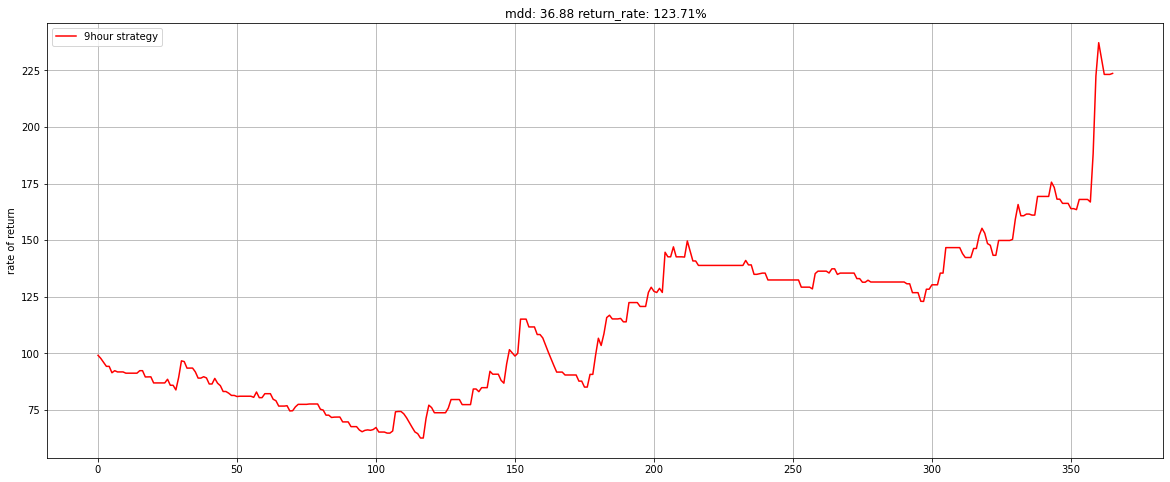

In [8]:
visualize_return_rate(df)

In [9]:
df

,Date,dr,btc_idx,crr,mdd
0,2020-09-10,-0.8840,0.39,0.991160,0.000000
1,2020-09-11,-1.4000,1.14,0.977284,1.400000
2,2020-09-12,-1.8000,0.06,0.959693,3.174800
3,2020-09-13,-1.8000,0.35,0.942418,4.917654
4,2020-09-14,0.0000,-0.02,0.942418,4.917654
5,2020-09-15,-3.0000,2.28,0.914146,7.770124
6,2020-09-16,1.0000,1.24,0.923287,6.847825
7,2020-09-17,-0.6000,0.87,0.917747,7.406738
8,2020-09-18,0.0000,-0.75,0.917747,7.406738
9,2020-09-19,0.0000,-0.27,0.917747,7.406738
